In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np  
from flopy.utils.lgrutil import Lgr ; from matplotlib.colors import ListedColormap ; from pathlib import Path
from flopy.plot.styles import styles ; import pandas as pd ; from modflow_devtools.misc import get_env, timed ; import matplotlib as mpl
write=get_env("WRITE", True);run=get_env("RUN", True);plot=get_env("PLOT", True)
plot_show=get_env("PLOT_SHOW", True);plot_save = get_env("PLOT_SAVE", True)  

In [2]:
sim_name = "09_nwt_p03" ; output_folder = Path("./09_ex_nwt_p03") ; output_folder.mkdir(exist_ok=True) ; name = sim_name 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-nwt-p03'
fname_A=os.path.join(path,"bottom.txt")      ; fname_B=os.path.join(path,"recharge_high.txt") 

In [3]:
length_units = "meters" ; time_units = "days" ; parameters = {"ex-gwf-nwt-p03a": {"recharge": "high",},"ex-gwf-nwt-p03b": {"recharge": "low"}}
nper = 1 ;  nlay = 1 ;  nrow = 80 ;  ncol = 80 ;  delr = 100 ;  delc = 100 ;  top = 200 ;  k11 = 1 ;  H1 = 24 ;  
nouter = 500 ;  ninner = 500 ;  hclose = 0.000000001 ;  rclose = 0.000001 ;  vmin, vmax = 20, 60 ; smin, smax = 0, 25 ; bmin, bmax = 0, 90

vlevels = np.arange(vmin, vmax + 5, 5) ; slevels = np.arange(smin, smax + 5, 5) ; blevels = np.arange(bmin + 10, bmax, 10)
vcolor = "black" ; scolor = "black" ; bcolor = "black" 
tdis_ds = ((365.0, 1, 1.0),) ; extents = (0, delr * ncol, 0, delc * nrow) ; shape3d = (nlay, nrow, ncol) ; ticklabels = np.arange(0, 10000, 2000)
botm      = np.loadtxt(fname_A).reshape(shape3d)     ; strt = botm + 20.0   
rch_high  = np.loadtxt(fname_B) ; rch_low = rch_high.copy() * 1e-3 ; chd_spd = [[0, i, ncol - 1, H1] for i in (45, 46, 47)]

In [4]:
def build_models(name, recharge = "high"):
    sim_ws = os.path.join (workspace, name)
    sim = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim ,print_option="all" ,complexity="simple" ,linear_acceleration="bicgstab" ,outer_maximum=nouter,
                           outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose)
    gwf = flopy.mf6.ModflowGwf (sim,modelname=sim_name,newtonoptions="newton under_relaxation")
    flopy.mf6.ModflowGwfdis (gwf, length_units=length_units, nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf (gwf, icelltype=1, k=k11)
    flopy.mf6.ModflowGwfic (gwf, strt=strt)
    flopy.mf6.ModflowGwfchd (gwf, stress_period_data=chd_spd)
    if recharge == "high":
        rch = rch_high
    elif recharge == "low":
        rch = rch_low
    flopy.mf6.ModflowGwfrcha (gwf, recharge = rch)                                              ; head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc (gwf,head_filerecord=head_filerecord,saverecord=[("HEAD", "ALL")])
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)  ; assert success, buff

# **scenario(0) dry cells (1) "effect" ON**

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]      ; params = parameters[key].copy()       ; sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
scenario(0) # scenario(1)

run_models took 349.04 ms


In [6]:
def create_figure(nsubs=1, size=(4, 4)):
    fig = plt.figure(figsize=size, constrained_layout=False) ; gs=mpl.gridspec.GridSpec(ncols=10, nrows=7, figure=fig, wspace=5) ; plt.axis("off")
    axes = []
    if nsubs == 1:
        axes.append(fig.add_subplot(gs[:5, :]))
    elif nsubs == 2:
        axes.append(fig.add_subplot(gs[:6, :5]))  ; axes.append(fig.add_subplot(gs[:6, 5:], sharey=axes[0]))
    for ax in axes:
        ax.set_xlim(extents[:2])  ; ax.set_ylim(extents[2:])  ; ax.set_aspect("equal")  ; ax.set_xticks(ticklabels) ; ax.set_yticks(ticklabels)
    axes.append(fig.add_subplot(gs[5:, :]))  ; ax = axes[-1]  ; ax.set_xlim(0, 1)  ; ax.set_ylim(0, 1)
    ax.axis("off") ; ax.set_xticks([]) ; ax.set_yticks([]) ; ax.spines["top"].set_color("none") ; ax.spines["bottom"].set_color("none")
    ax.spines["left"].set_color("none") ; ax.spines["right"].set_color("none") ; ax.patch.set_alpha(0.0)
    return fig, axes

In [7]:
def plot_results(idx, sim, silent=True):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name) ; bot = gwf.dis.botm.array
#        if idx == 0:
#            plot_grid(gwf, silent=silent) ; plot_recharge(gwf, silent=silent)
        hobj = gwf.output.head()  ; times = hobj.get_times()     ; head = hobj.get_data(totim=times[0])  
        imask = head <= bot + 0.001 ; head[imask] = -1e30        ; sat_thick = head - botm ; sat_thick[imask] = -1e30
        fig, axes = create_figure(nsubs=2, size=(6.3, 5.6))  
        ax = axes[0] ; mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)  # _____________________________________________
        h_coll = mm.plot_array(head, vmin=vmin, vmax=vmax, masked_values=(1e30, -1e30), zorder=10)
        cv = mm.contour_array(head, masked_values=(1e30, -1e30), levels=vlevels, linewidths=0.5, linestyles="-", colors=vcolor, zorder=10)
        plt.clabel(cv, fmt="%1.0f", zorder=10)    ; mm.plot_bc("CHD", color="cyan", zorder=11)
        cbar = plt.colorbar(h_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f") ; cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Water level, $m$")   ; ax.set_xlabel("x-coordinate, in meters") ; ax.set_ylabel("y-coordinate, in meters") ; 
        styles.heading(ax, letter="A")            ; styles.remove_edge_ticks(ax)

        ax = axes[1] ; mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)  # _____________________________________________
        s_coll = mm.plot_array(sat_thick, vmin=smin, vmax=smax, masked_values=(1e30, -1e30), zorder=10)
        cv = mm.contour_array(sat_thick, masked_values=(1e30, -1e30), levels=slevels,linewidths=0.5,linestyles=":",colors=scolor,zorder=10)
        plt.clabel(cv, fmt="%1.0f", zorder=10)           ; mm.plot_bc("CHD", color="cyan", zorder=11)
        cbar = plt.colorbar(s_coll, shrink=0.8, orientation="horizontal", ax=ax, format="%.0f") ; cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Saturated thickness, $m$")  ; ax.set_xlabel("x-coordinate, in meters")
        styles.heading(ax, letter="B")                   ; styles.remove_edge_ticks(ax)

        ax = axes[-1]
        ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="cyan",mec="cyan",label="Constant Head")
        ax.plot(-10000, -10000, lw=0.5, ls="-", color=vcolor, label="Head contour, m")
        ax.plot(-10000,-10000,lw=0.5,ls=":",color=scolor,label="Saturated thickness contour, m")
        styles.graph_legend(ax, loc="center", ncol=3)
        if plot_show:
            plt.show()

# **Scenario (0)__"recharge": "high"__**

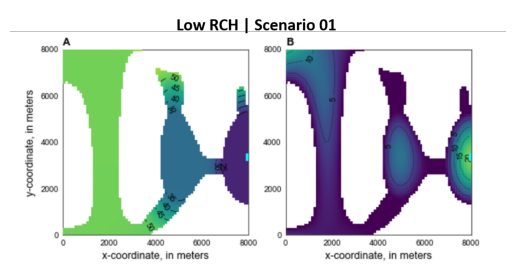

In [8]:
image = plt.imread('_aux\\09__c_1.png'); fig, ax = plt.subplots() ; ax.imshow(image) ; ax.axis('off') ; plt.show() 

# **Scenario (1)__"recharge": "low"__**

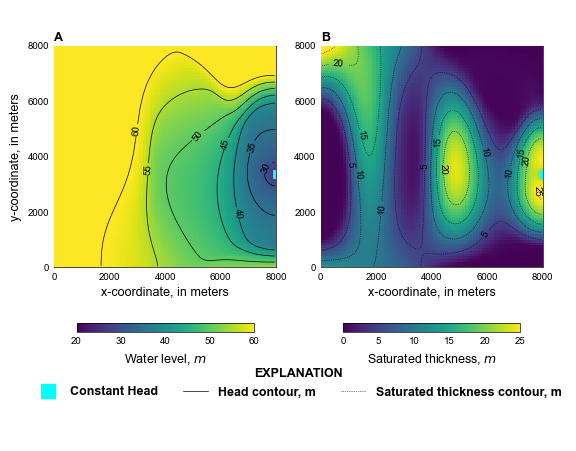

In [9]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]      ; params = parameters[key].copy()       ; sim = build_models(key, **params)
    if plot:
        plot_results(idx, sim, silent=silent)
scenario(0)

# **Botm**

ex-gwf-nwt-p03a
{'recharge': 'high'}


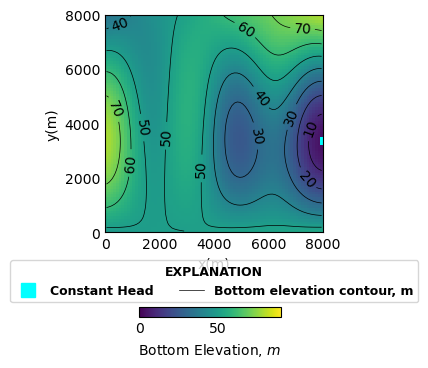

In [12]:
key = list(parameters.keys())[0] ; params = parameters[key].copy(); print(key); print(params)

sim = build_models(key, **params)  ; gwf = sim.get_model(sim_name) ; bot = gwf.dis.botm.array

bot = gwf.dis.botm.array ; fig, axes = create_figure(size=(3.15, 4)) ; ax = axes[0]
mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents) ; bot_coll = mm.plot_array(bot, vmin=bmin, vmax=bmax)
mm.plot_bc("CHD", color="cyan") ; cv = mm.contour_array(bot, levels=blevels, linewidths=0.5, linestyles="-", colors=bcolor)
plt.clabel(cv, fmt="%1.0f") ; ax.set_xlabel("x(m)") ; ax.set_ylabel("y(m)") ; styles.remove_edge_ticks(ax)
ax = axes[1]
ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="cyan",mec="cyan",label="Constant Head")  # Legend
ax.plot(-10000,-10000,lw=0.5,ls="-",color=bcolor,label="Bottom elevation contour, m")     # Legend
styles.graph_legend(ax, loc="center", ncol=2) ; cax = plt.axes([0.275, 0.125, 0.45, 0.025])
cbar = plt.colorbar(bot_coll, shrink=0.8, orientation="horizontal", cax=cax) ; 
cbar.ax.tick_params(size=0) ; cbar.ax.set_xlabel(r"Bottom Elevation, $m$") ;             plt.show()

# **RCH**

In [ ]:
fig, axes = create_figure(nsubs=1, size=(6.3, 5.6)) 

ax = axes[0] ; mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents) ; rch_coll = mm.plot_array(rch_high) ; mm.plot_bc("CHD", color="cyan")
cv = mm.contour_array(rch_high,levels=[1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6],linewidths=0.5,linestyles="-",colors="black")
plt.clabel(cv, fmt="%1.0e") ; cbar = plt.colorbar(rch_coll, shrink=0.4, orientation="horizontal", ax=ax, format="%.0e")
cbar.ax.tick_params(size=0) ; cbar.ax.set_xlabel(r"Recharge rate, $m/day$")
ax.set_xlabel("x(m)") ;ax.set_ylabel("y(m)") ; styles.heading(ax, letter="A") ; styles.remove_edge_ticks(ax)
ax.plot(-10000,-10000,lw=0,marker="s",ms=10,mfc="cyan",mec="cyan",label="Constant Head") ; styles.graph_legend(ax, loc="center", ncol=2) ; plt.show()

In [ ]:
np.savetxt(output_folder / "a_rch_high.csv", rch_high, delimiter=",")   # rch_low  #   botm
botm_B = np.loadtxt(fname_A) ; botm_C = np.loadtxt(fname_A).reshape(shape3d) 
np.savetxt(output_folder / "c_botm_B.csv", botm_B, delimiter=",") ; print(botm_B.shape)

In [ ]:
image = plt.imread('_aux\\09__d_1.png'); fig, ax = plt.subplots() ; ax.imshow(image) ; ax.axis('off') ; plt.show() 